# DRQN Trading Bot - Simplified Implementation

A minimal Deep Recurrent Q-Network for algorithmic trading, inspired by the original POC structure.


## 1. Install Dependencies


In [29]:
%pip install torch numpy pandas matplotlib tensorboard jupyter yfinance


Note: you may need to restart the kernel to use updated packages.


## 2. Import Libraries


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import random
import math
import os
from torch.utils.tensorboard import SummaryWriter
import yfinance as yf
from datetime import datetime, timedelta

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cpu


## 3. DRQN Model Architecture


In [31]:
class DRQN(nn.Module):
    """
    Deep Recurrent Q-Network for trading.

    Architecture:
    - Input: (batch_size, seq_len, state_size)
    - Layer 1: Linear(state_size, 256) + ELU
    - Layer 2: Linear(256, 256) + ELU
    - Layer 3: LSTM(256, 256)
    - Layer 4: Linear(256, 3) for 3 actions (bear, hold, bull)
    """

    def __init__(self, state_size=14, action_size=3):
        super(DRQN, self).__init__()

        self.state_size = state_size
        self.action_size = action_size

        # First two layers
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)

        # LSTM layer
        self.lstm = nn.LSTM(256, 256, batch_first=True)

        # Output layer
        self.fc3 = nn.Linear(256, action_size)

    def forward(self, x):
        # x shape: (batch_size, seq_len, state_size)
        batch_size, seq_len, _ = x.shape

        # Reshape for processing
        x = x.view(-1, self.state_size)  # (batch_size * seq_len, state_size)

        # First two layers
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))

        # Reshape back for LSTM
        x = x.view(batch_size, seq_len, -1)  # (batch_size, seq_len, 256)

        # LSTM
        lstm_out, _ = self.lstm(x)

        # Take the last output
        x = lstm_out[:, -1, :]  # (batch_size, 256)

        # Output layer
        x = self.fc3(x)  # (batch_size, 3)

        return x


## 4. Trading Environment


In [32]:
class TradingEnvironment:
    """
    Trading environment following the published DRQN approach.
    Consistent with train_drqn.py and validate_drqn.py.

    Actions:
    - 0: Bear (-1) - Short position
    - 1: Hold (0) - No position
    - 2: Bull (1) - Long position
    """

    def __init__(self, data, initial_balance=100000, trade_size=10000, spread=0.005, max_position_ratio=0.3):
        self.data = data
        self.initial_balance = initial_balance
        self.trade_size = trade_size
        self.spread = spread
        self.max_position_ratio = max_position_ratio  # Max 30% of portfolio in one position

        self.reset()

    def reset(self):
        """Reset environment to initial state."""
        self.balance = self.initial_balance
        self.position = 0  # Current position: -1, 0, or 1
        self.current_step = 0
        self.portfolio_values = [self.initial_balance]

        return self._get_state()

    def _get_state(self):
        """Get current state features following the paper's approach."""
        if self.current_step >= len(self.data) - 1:
            return None

        # Get current price
        current_price = float(self.data.iloc[self.current_step]['Close'])

        # Create state features (simplified version of the paper's approach)
        # The paper uses 8 delayed log returns + time features + previous action
        price_features = []

        # Add price-based features
        if self.current_step >= 8:
            # 8 delayed log returns (as in the paper)
            for i in range(8):
                if self.current_step - i - 1 >= 0:
                    prev_price = float(self.data.iloc[self.current_step - i - 1]['Close'])
                    log_return = np.log(current_price / prev_price)
                    price_features.append(log_return)
                else:
                    price_features.append(0.0)
        else:
            # Pad with zeros if not enough history
            price_features.extend([0.0] * 8)

        # Add time features (simplified)
        price_features.extend([
            float(self.current_step / len(self.data)),  # Normalized time
            float(self.position),  # Previous action
            float(self.balance / self.initial_balance),  # Normalized balance
        ])

        # Pad to 14 features total
        while len(price_features) < 14:
            price_features.append(0.0)

        return np.array(price_features[:14], dtype=np.float32)

    def step(self, action):
        """Execute action following the published paper's approach."""
        if self.current_step >= len(self.data) - 1:
            return None, 0, True

        current_price = float(self.data.iloc[self.current_step]['Close'])
        next_price = float(self.data.iloc[self.current_step + 1]['Close'])

        # Convert action to position (-1, 0, 1) following paper's logic
        new_position = action - 1  # 0->-1, 1->0, 2->1

        # Paper's trading logic:
        # - Bear (-1): Borrow stocks, sell at open, buy back at close
        # - Bull (1): Borrow money, buy at open, sell at close
        # - Hold (0): Do nothing

        # Calculate profit/loss from the action
        if new_position == 1:  # Bull transaction
            # Borrow money, buy at current_price, sell at next_price
            profit_loss = (next_price - current_price) * self.trade_size
        elif new_position == -1:  # Bear transaction
            # Borrow stocks, sell at current_price, buy back at next_price
            profit_loss = (current_price - next_price) * self.trade_size
        else:  # Hold (0)
            profit_loss = 0

        # Commission cost (only for non-hold actions)
        commission_cost = 0
        if new_position != 0:
            commission_cost = self.trade_size * self.spread

        # Net profit/loss
        net_pnl = profit_loss - commission_cost

        # Update balance (paper's approach: balance absorbs profits/losses)
        self.balance += net_pnl

        # Update position
        self.position = new_position

        # Update portfolio value
        portfolio_value = self.balance
        self.portfolio_values.append(portfolio_value)

        # Reward is the actual portfolio change (paper's approach)
        reward = net_pnl

        self.current_step += 1

        # Check if done
        done = self.current_step >= len(self.data) - 1

        next_state = self._get_state() if not done else None

        return next_state, reward, done


## 5. DRQN Agent


In [33]:
class DRQNAgent:
    """
    DRQN Agent with experience replay following the published approach.
    Consistent with train_drqn.py and validate_drqn.py.
    """

    def __init__(self, state_size=14, action_size=3, lr=0.001, gamma=0.99, epsilon=1.0,
                 epsilon_min=0.05, epsilon_decay=0.9995, batch_size=32, memory_size=10000):
        self.state_size = state_size
        self.action_size = action_size
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size

        # Networks
        self.q_network = DRQN(state_size, action_size).to(device)
        self.target_network = DRQN(state_size, action_size).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr, weight_decay=1e-5)

        # Copy weights to target network
        self.target_network.load_state_dict(self.q_network.state_dict())

        # Experience replay
        self.memory = deque(maxlen=memory_size)

        # Action tracking for balanced exploration
        self.action_counts = {0: 0, 1: 0, 2: 0}
        self.total_actions = 0

    def act(self, state, training=True):
        """Choose action using improved epsilon-greedy policy with balanced exploration."""
        if training and np.random.random() <= self.epsilon:
            # Balanced exploration - favor under-explored actions
            action_probs = [1.0 / (self.action_counts[i] + 1) for i in range(self.action_size)]
            total_prob = sum(action_probs)
            action_probs = [p / total_prob for p in action_probs]
            action = np.random.choice(self.action_size, p=action_probs)
        else:
            with torch.no_grad():
                # Convert single state to sequence format (batch_size=1, seq_len=1, state_size)
                state_tensor = torch.FloatTensor(state).unsqueeze(0).unsqueeze(0).to(device)
                q_values = self.q_network(state_tensor)
                action = q_values.argmax().item()

        # Track action for balanced exploration
        if training:
            self.action_counts[action] += 1
            self.total_actions += 1

        return action

    def remember(self, state, action, reward, next_state, done):
        """Store experience in replay buffer."""
        self.memory.append((state, action, reward, next_state, done))

    def remember_action_augmentation(self, state, all_actions, all_rewards, next_state, done):
        """Store Action Augmentation experiences (paper's key innovation)."""
        # Store transitions for ALL possible actions, not just the chosen one
        for action, reward in zip(all_actions, all_rewards):
            self.memory.append((state, action, reward, next_state, done))

    def replay(self):
        """Train the network on a batch of experiences."""
        if len(self.memory) < self.batch_size:
            return 0.0

        batch = random.sample(self.memory, self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Filter out None next_states
        valid_indices = [i for i, ns in enumerate(next_states) if ns is not None]
        if len(valid_indices) < self.batch_size // 2:
            return 0.0

        # Use only valid transitions
        states = [states[i] for i in valid_indices]
        actions = [actions[i] for i in valid_indices]
        rewards = [rewards[i] for i in valid_indices]
        next_states = [next_states[i] for i in valid_indices]
        dones = [dones[i] for i in valid_indices]

        # Convert to tensors with proper sequence format
        states = torch.FloatTensor(states).unsqueeze(1).to(device)  # (batch, seq_len=1, state_size)
        actions = torch.LongTensor(actions).to(device)
        rewards = torch.FloatTensor(rewards).to(device)
        next_states = torch.FloatTensor(next_states).unsqueeze(1).to(device)  # (batch, seq_len=1, state_size)
        dones = torch.BoolTensor(dones).to(device)

        # Get current Q-values
        current_q_values = self.q_network(states).gather(1, actions.unsqueeze(1))

        # Get next Q-values
        with torch.no_grad():
            next_q_values = self.target_network(next_states).max(1)[0]
            target_q_values = rewards + (self.gamma * next_q_values * ~dones)

        # Compute loss
        loss = F.mse_loss(current_q_values.squeeze(), target_q_values)

        # Optimize
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # Update epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

        return loss.item()

    def update_target_network(self):
        """Copy weights from main network to target network."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def load_model(self, model_path):
        """Load trained model weights (consistent with validate_drqn.py)."""
        self.q_network.load_state_dict(torch.load(model_path, map_location=device))
        self.q_network.eval()  # Set to evaluation mode
        print(f"Model loaded from {model_path}")


## 6. Load Data


In [34]:
# Download sample data using yfinance (consistent with train_drqn.py)
ticker = "AAPL"
start_date = datetime.now() - timedelta(days=365)
end_date = datetime.now()

print(f"Loading data for {ticker} from {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')}")

data = yf.download(ticker, start=start_date, end=end_date)

# Handle MultiIndex columns properly (consistent with train_drqn.py)
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

print(f"Downloaded {len(data)} days of data")
print("Data columns:", data.columns.tolist())
print("Data shape:", data.shape)
print(data.head())


Loading data for AAPL from 2024-10-19 to 2025-10-19


/var/folders/hh/m_2w1wtd1pnc8fytkrbhl9sm0000gn/T/ipykernel_44117/3968928176.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Downloaded 249 days of data
Data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data shape: (249, 5)
Price            Close        High         Low        Open    Volume
Date                                                                
2024-10-21  235.384506  235.752803  233.363911  233.363911  36254500
2024-10-22  234.767395  235.125728  231.522502  232.806520  38846600
2024-10-23  229.691010  234.050724  226.704907  232.995637  52287000
2024-10-24  229.501877  229.750719  227.351880  228.914599  31109500
2024-10-25  230.337997  232.139610  228.506525  228.675736  38802300


## 7. Training Loop


In [35]:
# Initialize environment and agent (consistent with train_drqn.py)
env = TradingEnvironment(
    data,
    initial_balance=100000,
    trade_size=10000,
    spread=0.005
)

agent = DRQNAgent(
    lr=0.001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    batch_size=32,
    memory_size=10000
)

# Training parameters (consistent with train_drqn.py)
episodes = 100
update_target_freq = 10
print_freq = 10

# Setup TensorBoard (consistent with train_drqn.py)
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
run_name = f"drqn_{ticker}_ep{episodes}_lr0.001_bal100000_{timestamp}"
writer = SummaryWriter(f'runs/{run_name}')

# Training loop with early stopping (consistent with train_drqn.py)
episode_rewards = []
episode_portfolios = []
episode_losses = []
best_portfolio = -float('inf')
patience_counter = 0
early_stop_patience = 50

print(f"Starting DRQN training with parameters:")
print(f"  Ticker: {ticker}")
print(f"  Episodes: {episodes}")
print(f"  Initial Balance: $100,000")
print(f"  Trade Size: $10,000")
print(f"  Spread: 0.005")
print(f"  Learning Rate: 0.001")
print(f"  Device: {device}")

print("\nStarting training...")
for episode in range(episodes):
    state = env.reset()
    total_reward = 0
    step_count = 0

    while state is not None:
        # Action Augmentation: Evaluate ALL possible actions (paper's key innovation)
        all_actions = [0, 1, 2]  # Bear, Hold, Bull
        all_rewards = []

        # Calculate rewards for all possible actions
        for action in all_actions:
            # Temporarily execute each action to get reward
            temp_env = env
            temp_state = temp_env.current_step
            temp_balance = temp_env.balance
            temp_position = temp_env.position

            # Simulate action
            if temp_env.current_step >= len(temp_env.data) - 1:
                reward = 0
            else:
                current_price = float(temp_env.data.iloc[temp_env.current_step]['Close'])
                next_price = float(temp_env.data.iloc[temp_env.current_step + 1]['Close'])

                # Calculate profit/loss for this action
                new_position = action - 1  # 0->-1, 1->0, 2->1

                if new_position == 1:  # Bull
                    profit_loss = (next_price - current_price) * temp_env.trade_size
                elif new_position == -1:  # Bear
                    profit_loss = (current_price - next_price) * temp_env.trade_size
                else:  # Hold
                    profit_loss = 0

                commission_cost = 0
                if new_position != 0:
                    commission_cost = temp_env.trade_size * temp_env.spread

                reward = profit_loss - commission_cost

            all_rewards.append(reward)

        # Agent selects action (can use epsilon-greedy or other strategy)
        action = agent.act(state)
        reward = all_rewards[action]

        # Environment executes the chosen action
        next_state, actual_reward, done = env.step(action)

        # Store Action Augmentation experiences
        if next_state is not None:
            agent.remember_action_augmentation(state, all_actions, all_rewards, next_state, done)

        total_reward += reward
        state = next_state
        step_count += 1

        if done:
            break

    # Train the agent on collected experiences
    loss = agent.replay()

    # Update target network periodically
    if episode % update_target_freq == 0:
        agent.update_target_network()

    # Log results
    final_portfolio = env.portfolio_values[-1]
    episode_rewards.append(total_reward)
    episode_portfolios.append(final_portfolio)
    episode_losses.append(loss if loss else 0)

    # Early stopping check
    if final_portfolio > best_portfolio:
        best_portfolio = final_portfolio
        patience_counter = 0
    else:
        patience_counter += 1

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping at episode {episode} (no improvement for {early_stop_patience} episodes)")
        break

    # TensorBoard logging
    writer.add_scalar('Reward/Episode', total_reward, episode)
    writer.add_scalar('Portfolio/Value', final_portfolio, episode)
    writer.add_scalar('Loss/Training', loss if loss else 0, episode)
    writer.add_scalar('Epsilon/Value', agent.epsilon, episode)

    # Print progress with action distribution (consistent with train_drqn.py)
    if episode % print_freq == 0:
        action_dist = {i: agent.action_counts[i] / max(agent.total_actions, 1) * 100 for i in range(3)}
        print(f"Episode {episode:4d} | Reward: {total_reward:8.2f} | Portfolio: ${final_portfolio:10,.2f} | Epsilon: {agent.epsilon:.3f} | Actions: Bear:{action_dist[0]:.1f}% Hold:{action_dist[1]:.1f}% Bull:{action_dist[2]:.1f}%")

writer.close()
print("Training completed!")


Starting DRQN training with parameters:
  Ticker: AAPL
  Episodes: 100
  Initial Balance: $100,000
  Trade Size: $10,000
  Spread: 0.005
  Learning Rate: 0.001
  Device: cpu

Starting training...
Episode    0 | Reward: -554368.37 | Portfolio: $-454,368.37 | Epsilon: 0.995 | Actions: Bear:33.9% Hold:33.9% Bull:32.3%
Episode   10 | Reward: -230593.00 | Portfolio: $-130,593.00 | Epsilon: 0.946 | Actions: Bear:32.2% Hold:33.7% Bull:34.1%
Episode   20 | Reward: -794868.17 | Portfolio: $-694,868.17 | Epsilon: 0.900 | Actions: Bear:32.0% Hold:34.2% Bull:33.7%
Episode   30 | Reward: 300773.81 | Portfolio: $400,773.81 | Epsilon: 0.856 | Actions: Bear:31.5% Hold:34.7% Bull:33.8%
Episode   40 | Reward: 489123.78 | Portfolio: $589,123.78 | Epsilon: 0.814 | Actions: Bear:30.9% Hold:35.1% Bull:34.0%
Episode   50 | Reward: -893021.38 | Portfolio: $-793,021.38 | Epsilon: 0.774 | Actions: Bear:30.2% Hold:34.5% Bull:35.3%
Episode   60 | Reward: -207887.28 | Portfolio: $-107,887.28 | Epsilon: 0.737 | Act

## 8. Visualization


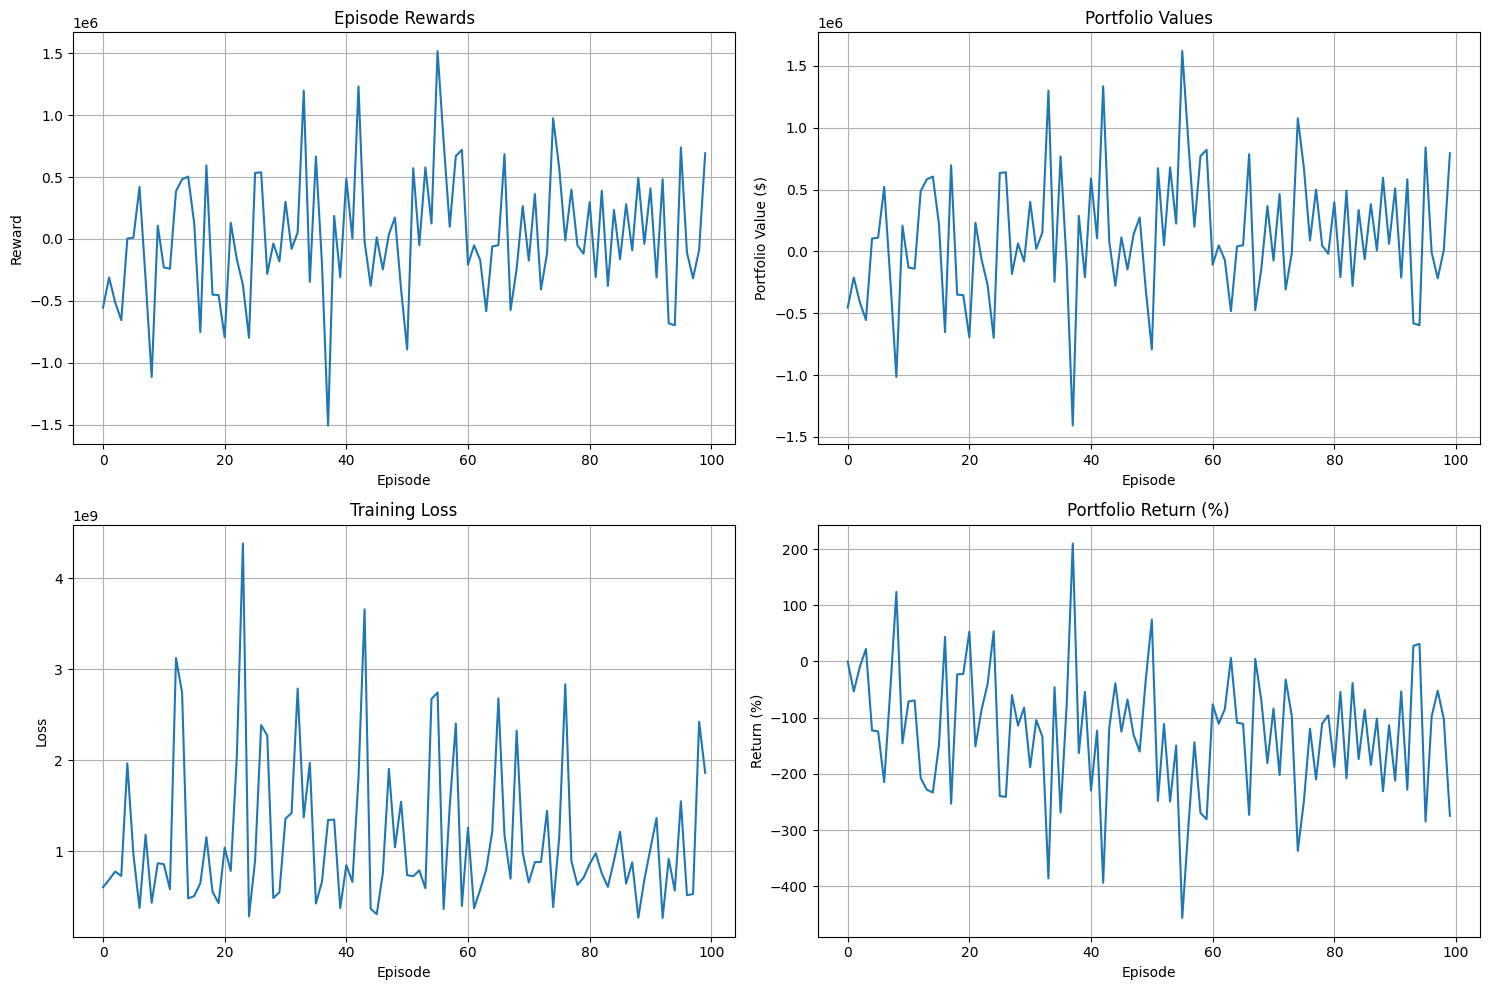


Final Results:
Initial Portfolio: $100,000.00
Final Portfolio: $793,037.30
Total Return: 693.04%
Buy & Hold Return: 7.18%
Outperformance: 685.86%
Action Distribution:
  Bear: 27.9%
  Hold: 38.1%
  Bull: 34.0%


In [36]:
# Plot training results (consistent with train_drqn.py and validate_drqn.py)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Episode rewards
axes[0, 0].plot(episode_rewards)
axes[0, 0].set_title('Episode Rewards')
axes[0, 0].set_xlabel('Episode')
axes[0, 0].set_ylabel('Reward')
axes[0, 0].grid(True)

# Portfolio values
axes[0, 1].plot(episode_portfolios)
axes[0, 1].set_title('Portfolio Values')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Portfolio Value ($)')
axes[0, 1].grid(True)

# Training loss
axes[1, 0].plot(episode_losses)
axes[1, 0].set_title('Training Loss')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].grid(True)

# Return percentage
returns = [(p - episode_portfolios[0]) / episode_portfolios[0] * 100
           for p in episode_portfolios]
axes[1, 1].plot(returns)
axes[1, 1].set_title('Portfolio Return (%)')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Return (%)')
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Print final results (consistent with train_drqn.py)
initial_value = env.initial_balance
final_value = env.portfolio_values[-1]
return_pct = (final_value - initial_value) / initial_value * 100

# Calculate buy-and-hold baseline (consistent with validate_drqn.py)
initial_price = float(data.iloc[0]['Close'])
final_price = float(data.iloc[-1]['Close'])
buy_hold_return = (final_price - initial_price) / initial_price * 100

# Calculate action distribution (consistent with validate_drqn.py)
action_distribution = {
    'bear': agent.action_counts[0] / max(agent.total_actions, 1) * 100,
    'hold': agent.action_counts[1] / max(agent.total_actions, 1) * 100,
    'bull': agent.action_counts[2] / max(agent.total_actions, 1) * 100
}

print(f"\nFinal Results:")
print(f"Initial Portfolio: ${initial_value:,.2f}")
print(f"Final Portfolio: ${final_value:,.2f}")
print(f"Total Return: {return_pct:.2f}%")
print(f"Buy & Hold Return: {buy_hold_return:.2f}%")
print(f"Outperformance: {return_pct - buy_hold_return:.2f}%")
print(f"Action Distribution:")
print(f"  Bear: {action_distribution['bear']:.1f}%")
print(f"  Hold: {action_distribution['hold']:.1f}%")
print(f"  Bull: {action_distribution['bull']:.1f}%")


## 9. TensorBoard

Run this in a separate terminal to view training metrics:
```bash
tensorboard --logdir=runs --port=6006
```

Then open http://localhost:6006 in your browser.


## 10. Quick Test

Run this cell to test if everything is working correctly:


In [37]:
# Quick test to verify everything works (consistent with validate_drqn.py)
print("Testing DRQN model...")

# Test model (consistent with train_drqn.py architecture)
model = DRQN(state_size=14, action_size=3)
test_input = torch.randn(1, 1, 14)  # (batch_size=1, seq_len=1, state_size=14)
output = model(test_input)
print(f"Model output shape: {output.shape}")
print(f"Model output: {output}")

# Test environment (consistent with train_drqn.py)
env = TradingEnvironment(data, initial_balance=100000, trade_size=10000, spread=0.005)
state = env.reset()
print(f"Environment state shape: {state.shape}")
print(f"Environment state: {state}")

# Test agent (consistent with train_drqn.py)
agent = DRQNAgent(
    lr=0.001,
    gamma=0.99,
    epsilon=1.0,
    epsilon_min=0.01,
    epsilon_decay=0.995,
    batch_size=32,
    memory_size=10000
)
action = agent.act(state)
print(f"Agent action: {action}")

# Test action augmentation (consistent with train_drqn.py)
print("Testing action augmentation...")
all_actions = [0, 1, 2]
all_rewards = [0.1, 0.0, -0.1]  # Sample rewards
agent.remember_action_augmentation(state, all_actions, all_rewards, state, False)
print(f"Memory size: {len(agent.memory)}")

print("✅ All tests passed! The notebook is ready to use.")


Testing DRQN model...
Model output shape: torch.Size([1, 3])
Model output: tensor([[-0.0364, -0.0318,  0.0092]], grad_fn=<AddmmBackward0>)
Environment state shape: (14,)
Environment state: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
Agent action: 0
Testing action augmentation...
Memory size: 3
✅ All tests passed! The notebook is ready to use.


In [38]:
## 11. Model Saving and Loading (Consistent with train_drqn.py and validate_drqn.py)

# Save the trained model (consistent with train_drqn.py)
model_path = f"models/drqn_{ticker}_ep{episodes}_lr0.001_bal100000_{timestamp}.pt"
os.makedirs("models", exist_ok=True)
torch.save(agent.q_network.state_dict(), model_path)
print(f"Model saved to {model_path}")

# Load and test the saved model (consistent with validate_drqn.py)
print("\nTesting model loading...")
loaded_agent = DRQNAgent()
loaded_agent.load_model(model_path)

# Test loaded model
test_state = env.reset()
loaded_action = loaded_agent.act(test_state)
print(f"Loaded model action: {loaded_action}")

print("✅ Model saving and loading works correctly!")


Model saved to models/drqn_AAPL_ep100_lr0.001_bal100000_20251019_153354.pt

Testing model loading...
Model loaded from models/drqn_AAPL_ep100_lr0.001_bal100000_20251019_153354.pt
Loaded model action: 1
✅ Model saving and loading works correctly!


## Debug: Check Data Structure


In [39]:
# Debug: Check the data structure
print("Data columns:", data.columns.tolist())
print("Data index type:", type(data.index))
print("First few rows:")
print(data.head())

# Try to access Close column
try:
    print("Close column exists:", 'Close' in data.columns)
    print("Sample Close values:", data['Close'].head())
except Exception as e:
    print("Error accessing Close:", e)
    print("Available columns:", data.columns.tolist())


Data columns: ['Close', 'High', 'Low', 'Open', 'Volume']
Data index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
First few rows:
Price            Close        High         Low        Open    Volume
Date                                                                
2024-10-21  235.384506  235.752803  233.363911  233.363911  36254500
2024-10-22  234.767395  235.125728  231.522502  232.806520  38846600
2024-10-23  229.691010  234.050724  226.704907  232.995637  52287000
2024-10-24  229.501877  229.750719  227.351880  228.914599  31109500
2024-10-25  230.337997  232.139610  228.506525  228.675736  38802300
Close column exists: True
Sample Close values: Date
2024-10-21    235.384506
2024-10-22    234.767395
2024-10-23    229.691010
2024-10-24    229.501877
2024-10-25    230.337997
Name: Close, dtype: float64


In [40]:
# Test data access
print("Testing data access:")
print("Close column exists:", 'Close' in data.columns)
print("Volume column exists:", 'Volume' in data.columns)
print("Sample Close value:", data['Close'].iloc[0])
print("Sample Volume value:", data['Volume'].iloc[0])


Testing data access:
Close column exists: True
Volume column exists: True
Sample Close value: 235.38450622558594
Sample Volume value: 36254500
